## Kernelized Support Vector Machines

Previously, we looked at linear support vector machines for classification.  *Kernelized Support Vector Machines* (or *SVMs*) are an extension that allows for more complex models that are not defined simply by hyperplanes in the input space.  

While there are SVMs for both classification and regression, we will restrict ourselves to the classification case, as implemented in SVC.  Similar concepts apply to Support Vector Regression , as implemented in *SVR*.

### Linear Models and Nonlinear Features

Here, we look at the synthetic two-class classification dataset, where each class is given by data sampled from a Gaussian distribution.

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

Text(0, 0.5, 'Feature 1')

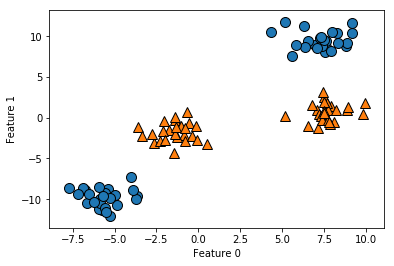

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

A linear model for classification can only separate points using a line, and will not be able to do a very good job on this dataset.

Text(0, 0.5, 'Feature 1')

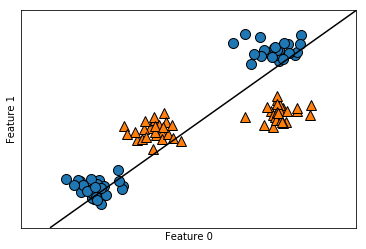

In [3]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Now, let's expand the set of input features, say by also adding the square of the second feature as a new feature.  Instead of representing each data point as a 2-D point (feature0, feature1), we now represent it as a 3-D point (feature0, feature1, feature1 ** 2).  We can illustrate this representation in a 3-D scatter plot.

Text(0.5, 0, 'feature1 ** 2')

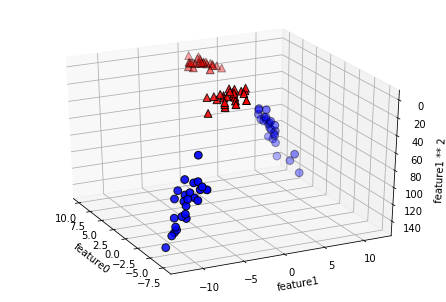

In [8]:
# Add the squared second feature
X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()

# Visualize in 3D
ax = Axes3D(figure, elev=-152, azim=26)

# Plot first all the points with y==0, then all with y==1
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

In the new representation of the data, it is now indeed possible to separate the two classes using a linear model, a plane in three dimensions. We can confirm this by fitting a linear model to the augmented data.

Text(0.5, 0, 'feature1 ** 2')

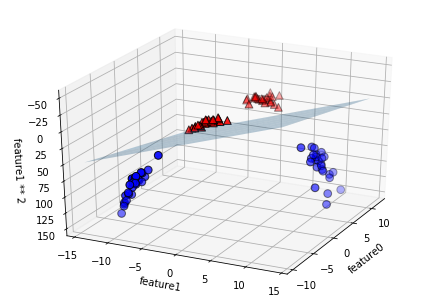

In [9]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# show linear decision boundary
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

As a function of the original features, the linear SVM model is not actually linear anymore. It is not a line, but more of an ellipse, as you can see from the plot created here.

Text(0, 0.5, 'Feature 1')

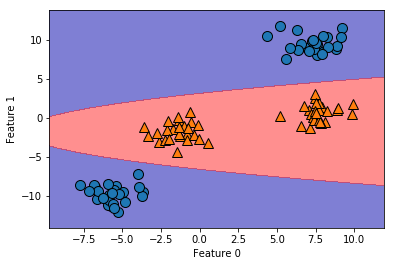

In [10]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

### The Kernel Trick

The lesson here is that adding nonlinear features to the representation of our data can make linear models much more powerful. However, often we don’t know which features to add, and adding many features (like all possible interactions in a 100-dimensional feature space) might make computation very expensive. Luckily, there is a clever mathematical trick that allows us to learn a classifier in a higher-dimensional space without actually computing the new, possibly very large representation. 

This is known as the *kernel trick*, and it works by directly computing the distance (more precisely, the scalar products) of the data points for the expanded feature representation, without ever actually computing the expansion.

There are two ways to map your data into a higher-dimensional space that are commonly used with support vector machines.

The first is the *polynomial kernel*, which computes all possible polynomials up to a certain degree of the original features (like feature1 ** 2 * feature2 ** 5).

The second is the *radial basis function (RBF) kernel*, also known as the *Gaussian kernel*. The Gaussian kernel is a bit harder to explain, as it corresponds to an infinite-dimensional feature space. One way to explain the Gaussian kernel is that it considers all possible polynomials of all degrees, but the importance of the features decreases for higher degrees.

In practice, the mathematical details behind the kernel SVM are not that important, though, and how an SVM with an RBF kernel makes a decision can be summarized quite easily—we’ll do so in the next section.

### Understanding SVMs

During training, the SVM learns how important each of the training data points is to represent the decision boundary between the two classes. Typically only a subset of the training points matter for defining the decision boundary: the ones that lie on the border between the classes. These are called *support vectors* and give the support vector machine its name.

To make a prediction for a new point, the distance to each of the support vectors is measured. A classification decision is made based on the distances to the support vector, and the importance of the support vectors that was learned during training (stored in the *dual_coef_ attribute* of SVC).

The distance between data points is measured by the *Gaussian kernel*:

    krbf(x1, x2) = exp (–ɣǁx1 - x2ǁ2)

Here, 
- *x1* and *x2* are data points
- *ǁ x1 - x2 ǁ* denotes Euclidean distance
- *ɣ (gamma)* is a parameter that controls the width of the Gaussian kernel

This plot shows the result of training a support vector machine on a two-dimensional two-class dataset. The decision boundary is shown in black, and the support vectors are larger points with the wide outline. The following code creates this plot by training an SVM on the forge dataset:

Text(0, 0.5, 'Feature 1')

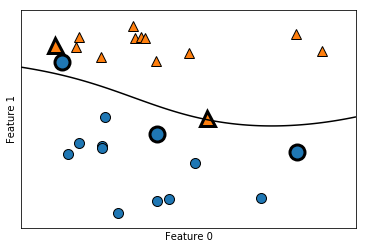

In [11]:
from sklearn.svm import SVC

X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

# plot support vectors
sv = svm.support_vectors_

# class labels of support vectors are given by the sign of the dual coefficients
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)

plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In this case, the SVM yields a very smooth and nonlinear (not a straight line) boundary. 

We adjusted two parameters here: 
- the *C* parameter 
- the *gamma* parameter